In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=5000)
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib widget

import pycolmap
import json

from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import gsplat
import torch
import pandas as pd

from plyfile import PlyData

def pprint(array, precision=4):
    with np.printoptions(
        precision=precision,
        suppress=True,
    ):
        print(array)


## Load camera parameters

### Colmap

load image and camera parameter from colmap output folder using pycolmap

In [48]:
colmap_dir = Path('/home/linus/workspace/data/mipnerf/bicycle/sparse/0/')
images_dir = Path('/home/linus/workspace/data/mipnerf/bicycle/images')
colmap_output = pycolmap.Reconstruction(colmap_dir)

colmap_image = colmap_output.images[1]
colmap_camera = colmap_output.cameras[colmap_image.camera_id]

width, height = colmap_camera.width, colmap_camera.height
fx, fy = colmap_camera.focal_length_x, colmap_camera.focal_length_y
cx, cy = colmap_camera.principal_point_x, colmap_camera.principal_point_y

view_matrix = np.vstack([colmap_image.cam_from_world.matrix(), [0, 0, 0, 1]])
image = np.array(Image.open(images_dir / f'{colmap_image.name}'))

### Nerf synthetic

In [2]:
import math
# from https://github.com/graphdeco-inria/gaussian-splatting/blob/main/utils/graphics_utils.py#L73
def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

nerf_dir = Path('/home/linus/workspace/data/nerf_data/nerf_synthetic/lego/')

pose_index = 64
subset = 'test'
with open(nerf_dir / f'transforms_{subset}.json') as json_file:
    info_dict = json.load(json_file)
frame = info_dict['frames'][pose_index]


pil_image = Image.open(nerf_dir / f'{frame["file_path"]}.png')
image = np.array(pil_image)
background = np.array([1, 1, 1])

image = image / 255
image = image[..., :3] * image[..., 3:4] + background * (1 - image[..., 3:4])

c2w = np.array(frame['transform_matrix'])
c2w[:3, 1:3] *= -1
view_matrix = np.linalg.inv(c2w)

height, width = pil_image.height, pil_image.width

fov_x = info_dict["camera_angle_x"]
fx = fov2focal(fov_x, width)
fov_y = focal2fov(fx, height)
fy = fov2focal(fov_y, height)

### NDC matrix

The next cell creates the NDC matrix, which transforms camera-centered coordinates to (right handed) Normalized Device Coordinates (NDC)

This matrix maps the camera frustum between `z=near` and `z=far` to a [-1,1]x[-1,1]x[0,1] cube

See [here](http://www.songho.ca/opengl/gl_projectionmatrix.html) or [here](https://www.scratchapixel.com/lessons/3d-basic-rendering/perspective-and-orthographic-projection-matrix/building-basic-perspective-projection-matrix.html) for more info and some visualizations

NOTE: As in the original implementation, this transformation assumes the camera center is in the middle of the image. There is a possible fix here: https://github.com/graphdeco-inria/gaussian-splatting/issues/144 though I haven't tried it

In [3]:
near, far = 0.01, 100 # hard-coded here https://github.com/graphdeco-inria/gaussian-splatting/blob/0b3519bca56e0ab38f85d5aa15d8aae7f526a4fe/scene/cameras.py#L48
tan_half_fov_x = width / 2 / fx
tan_half_fov_y = height / 2 / fy
ndc_matrix = np.array([
    [1/tan_half_fov_x, 0, 0, 0],
    [0, 1/tan_half_fov_y, 0, 0],
    [0, 0, far/(far-near), -near*far/(far-near)],
    [0, 0, 1, 0],
])

proj_matrix = ndc_matrix @ view_matrix

In [4]:
def dehomogenize(a):
    return a[:-1] / a[-1]

x_near, x_far = near * tan_half_fov_x, far * tan_half_fov_x
y_near, y_far = near * tan_half_fov_y, far * tan_half_fov_y
pprint(dehomogenize(ndc_matrix @ np.array([x_near, y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_near, -y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_near, y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_near, -y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_far, y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_far, -y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_far, y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_far, -y_far, far, 1])))

[1. 1. 0.]
[ 1. -1.  0.]
[-1.  1.  0.]
[-1. -1.  0.]
[1. 1. 1.]
[ 1. -1.  1.]
[-1.  1.  1.]
[-1. -1.  1.]


# Load gaussian splatting output

In [91]:
# plydata = PlyData.read('/home/linus/workspace/gaussian-splatting/output/ab091260-1/point_cloud/iteration_1000/point_cloud.ply').elements[0]
plydata = PlyData.read('/home/linus/workspace/gaussian-splatting/output/0ee29d72-3/point_cloud/iteration_30000/point_cloud.ply').elements[0]
means = np.array([
    plydata['x'],
    plydata['y'],
    plydata['z'],
]).T
n_gaussians = len(means)
opacities = plydata['opacity']
features_dc = np.array([
    plydata['f_dc_0'],
    plydata['f_dc_1'],
    plydata['f_dc_2'],
]).T

extra_f_names = [p.name for p in plydata.properties if p.name.startswith("f_rest_")]
extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
max_sh_degree = int(np.sqrt(len(extra_f_names) / 3 + 1) - 1)

features_extra = np.array([
    plydata[extra_f_name]
    for extra_f_name in extra_f_names
]).T.reshape(n_gaussians, 3, -1).transpose(0, 2, 1)

features = np.concatenate([features_dc[:, None], features_extra], axis=1)

scales = np.array([
    plydata['scale_0'],
    plydata['scale_1'],
    plydata['scale_2'],
]).T

quaternions = np.array([
    plydata['rot_0'],
    plydata['rot_1'],
    plydata['rot_2'],
    plydata['rot_3'],
]).T

# Render splats (gaussian-splatting)

Should exactly match the output of render.py from the original implementation ([here](https://github.com/graphdeco-inria/gaussian-splatting))

In [94]:
resolution_factor = 1
settings = GaussianRasterizationSettings(
    image_height=round(height / resolution_factor),
    image_width=round(width / resolution_factor),
    tanfovx=tan_half_fov_x,
    tanfovy=tan_half_fov_y,
    bg=torch.ones(3, device="cuda"),
    scale_modifier=1.,
    viewmatrix=torch.tensor(view_matrix, device="cuda", dtype=torch.float32).T,
    projmatrix=torch.tensor(proj_matrix, device="cuda", dtype=torch.float32).T,
    sh_degree=max_sh_degree,
    campos=torch.tensor(np.linalg.inv(view_matrix)[:3, -1], device="cuda", dtype=torch.float32),
    prefiltered=False,
    debug=True,
)
rasterizer = GaussianRasterizer(settings)

rendered_image, radii = rasterizer(
    means3D=torch.tensor(means.copy(), device="cuda"),
    means2D=torch.zeros(means.copy().shape, device="cuda", requires_grad=True).retain_grad(),
    opacities=torch.sigmoid(torch.tensor(opacities[:, None].copy(), device="cuda")),
    shs=torch.tensor(features, device="cuda"),
    scales=torch.exp(torch.tensor(scales.copy(), device="cuda")),
    rotations=torch.nn.functional.normalize(torch.tensor(quaternions.copy(), device="cuda")),
)
rendered_image = rendered_image.permute(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


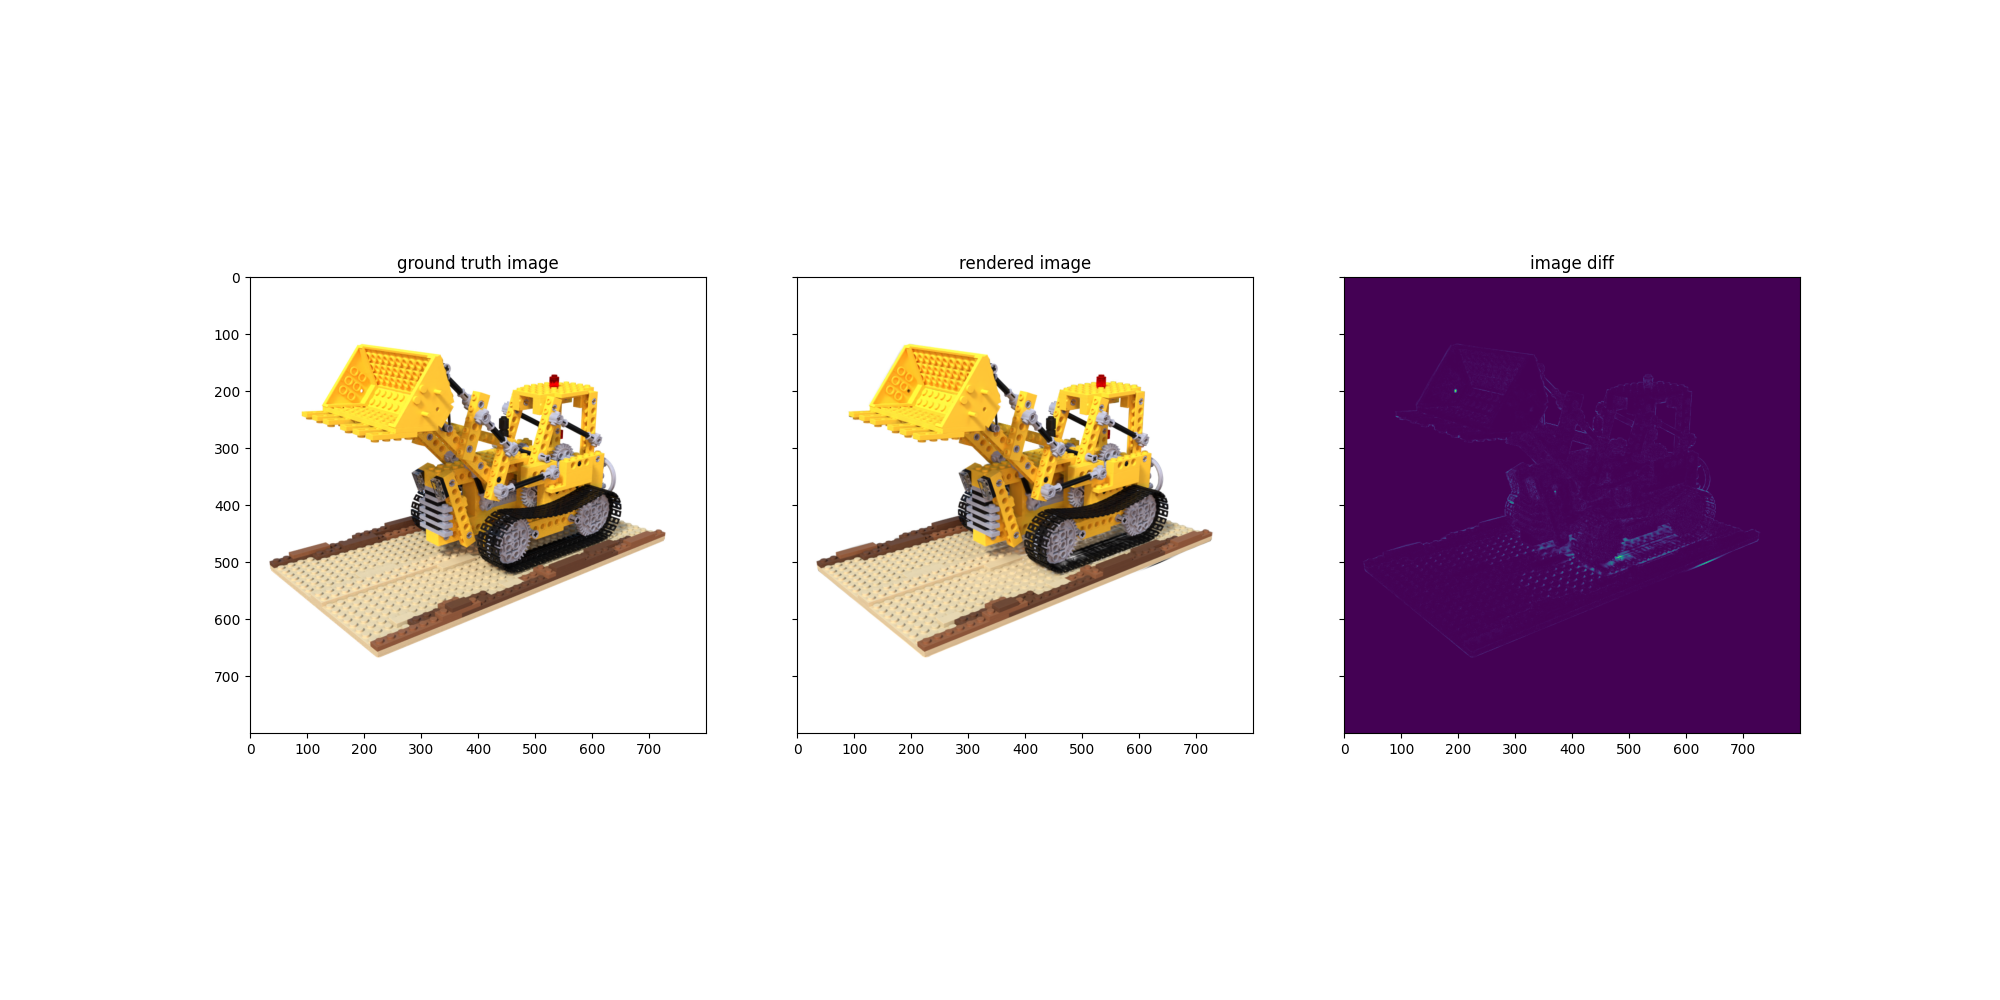

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)

ax[0].set_title('ground truth image')

ax[0].imshow(image)

ax[1].set_title('rendered image')
ax[1].imshow(rendered_image.detach().cpu().numpy())

ax[2].set_title('image diff')
ax[2].imshow(np.abs(rendered_image.detach().cpu().numpy() - image).mean(axis=-1))

# Render splats (gsplat)

In [97]:
resolution_factor = 1
means2d, depths, radii, conics, compensation, num_tiles_hit, cov3d = gsplat.project_gaussians(
    means3d=torch.tensor(means.copy(), device="cuda"),
    scales=torch.exp(torch.tensor(scales.copy(), device="cuda")),
    glob_scale=1.,
    quats=torch.nn.functional.normalize(torch.tensor(quaternions.copy(), device="cuda")),
    viewmat=torch.tensor(view_matrix, device="cuda", dtype=torch.float32),
    projmat=torch.tensor(proj_matrix, device="cuda", dtype=torch.float32),
    fx=fx,
    fy=fy,
    cx=width / 2,
    cy=height / 2,
    img_height=round(height / resolution_factor),
    img_width=round(width / resolution_factor),
    block_width=16,
    clip_thresh=0.01,
)

camera_center = np.linalg.inv(view_matrix)[:3, -1]
view_dirs = torch.nn.functional.normalize(torch.tensor(camera_center - means, device="cuda", dtype=torch.float32))
harmonics = gsplat.spherical_harmonics(
    degrees_to_use=max_sh_degree,
    viewdirs=view_dirs,
    coeffs=torch.tensor(features).to("cuda")
)
colors = harmonics + 0.5

rendered_image_gsplat, image_alpha = gsplat.rasterize_gaussians(
    xys=means2d,
    depths=depths,
    radii=radii,
    conics=conics,
    num_tiles_hit=num_tiles_hit,
    colors=colors,
    opacity=torch.sigmoid(torch.tensor(opacities[:, None].copy(), device="cuda")),
    img_height=round(height / resolution_factor),
    img_width=round(width / resolution_factor),
    block_width=16,
    background=torch.ones(3, device="cuda"),
    return_alpha=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


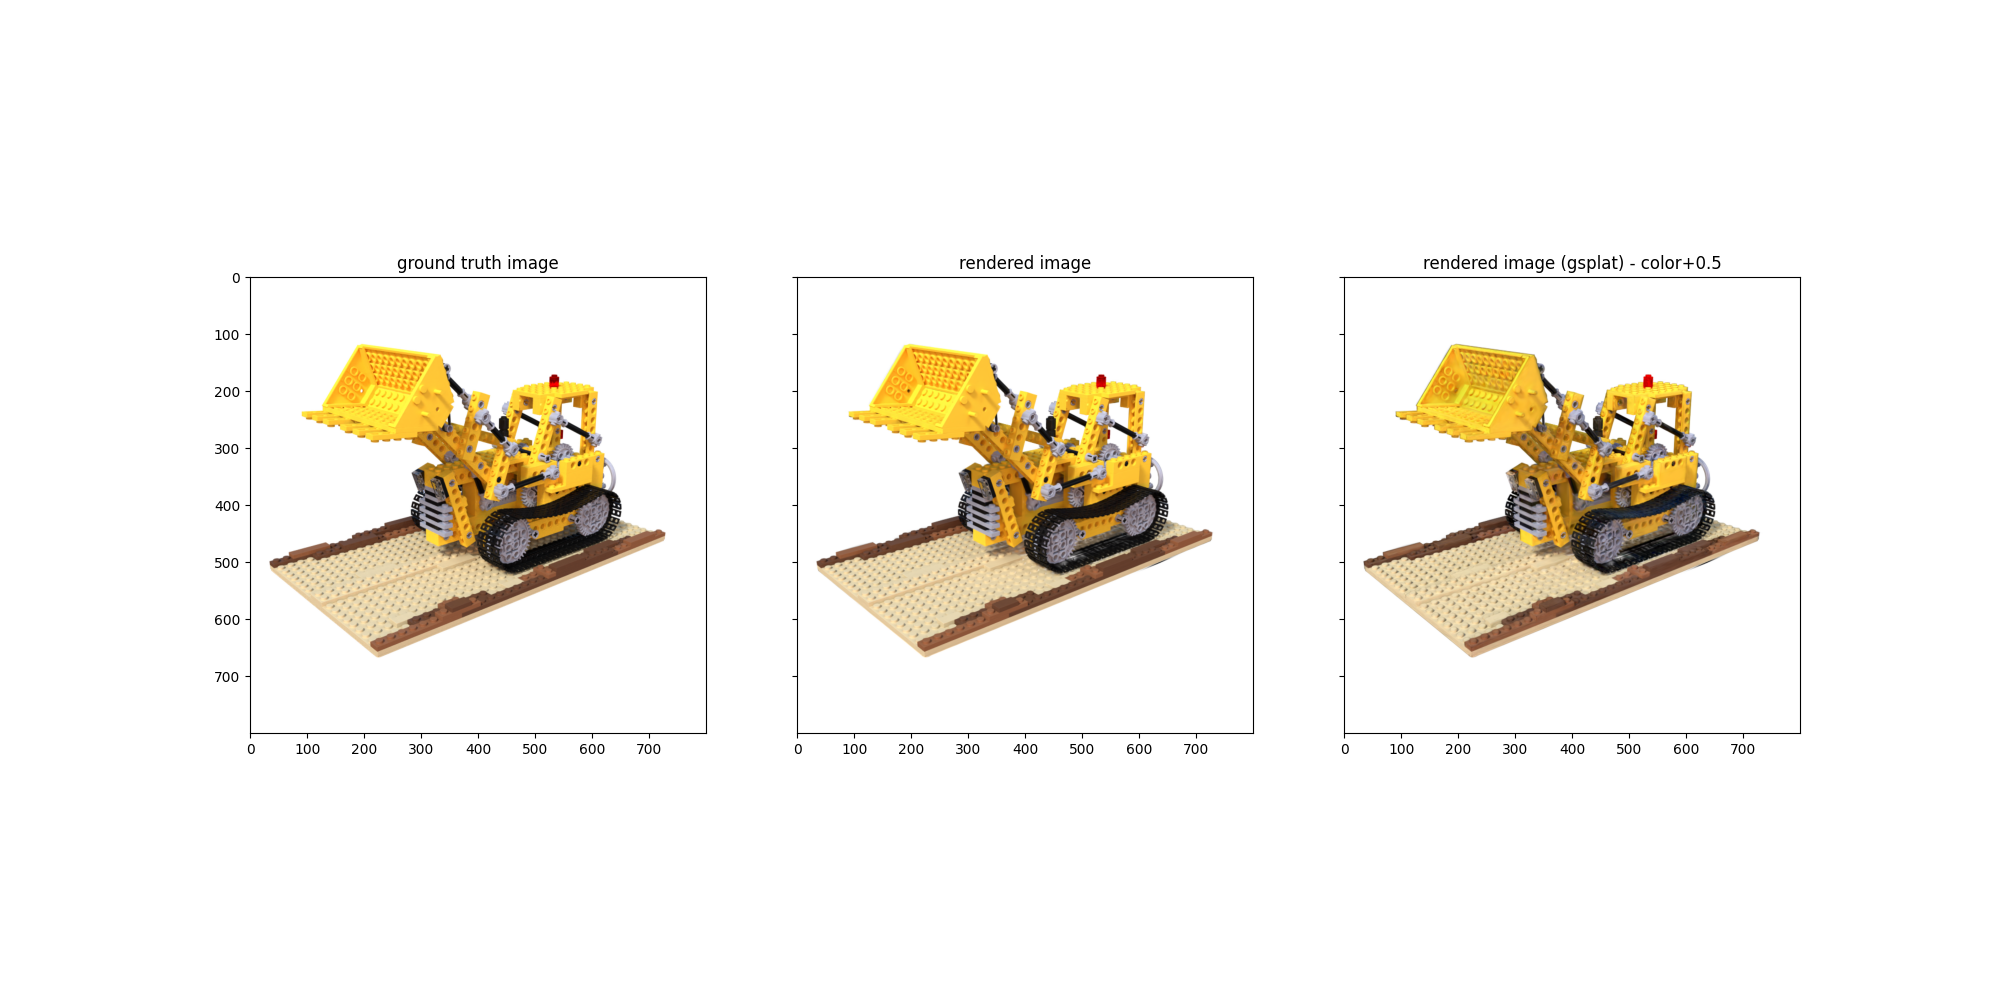

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)

ax[0].set_title('ground truth image')
ax[0].imshow(image)

ax[1].set_title('rendered image')
ax[1].imshow(rendered_image.detach().cpu().numpy())

ax[2].set_title('rendered image (gsplat) - color+0.5')
ax[2].imshow(rendered_image_gsplat.detach().cpu().numpy())